# 0. Install and Import Dependencies

In [372]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.4.0
astroid                      2.4.2
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
beautifulsoup4               4.11.2
cachetools                   5.3.0
certifi                      2022.12.7
charset-normalizer           3.1.0
colorama                     0.4.6
comm                         0.1.2
cycler                       0.10.0
debugpy                      1.6.6
decorator                    5.1.1
entrypoints                  0.4
executing                    1.2.0
filelock                     3.10.0
flatbuffers                  23.3.3
gast                         0.4.0
gdown                        4.6.4
google-auth                  2.16.2
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.51.3
h5py                         3.8.0
idna                         3.4
imageio 

In [373]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [374]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [375]:
tf.config.list_physical_devices('GPU')

[]

In [376]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [377]:
face_cascade = cv2.CascadeClassifier('C:\\ez\\PROEKT\\haarcascade_frontalface_default.xml')
mouth_cascade = cv2.CascadeClassifier('C:\\ez\\PROEKT\\haarcascade_mcs_mouth.xml')

In [378]:
def get_lips(frame):
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  # Обнаружить лица на изображении
  #faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  # Для каждого лица
  #for (x,y,w,h) in faces:
  # Выделить область интереса (ROI) для лица
  roi_gray = gray[:, :]
  roi_color = frame[:, :]
  # Обнаружить губы внутри ROI
  lips = mouth_cascade.detectMultiScale(roi_gray, 1.7, 11)
  # Для каждой пары губ
  for (lx,ly,lw,lh) in lips:
    return (lx, ly, lx + lw, ly + lh)

In [379]:
import gdown

In [380]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [381]:
from requests.api import request
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    # error_handler_x = []
    # error_handler_x = set(error_handler)

    # error_handler_y = []
    # error_handler_y = set(error_handler)
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        
        request_ans = get_lips(frame)
        if (request_ans != None):
          x1, y1, x2, y2 = request_ans[0], request_ans[1], request_ans[2], request_ans[3]
          #print("Coords: ", x1, y1, x2, y2, y2-y1, x2-x1)
          if (y2-y1 != 43 and x2-x1 != 72):
            continue
          frame = tf.image.rgb_to_grayscale(frame)
          frame = frame[y1:y2,x1:x2,:]
          frame = tf.image.resize(frame, size=(46, 140), method=tf.image.ResizeMethod.BILINEAR)
          frames.append(frame)
        #frames.append(frame[190:236,80:220,:])
        
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [382]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [383]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [384]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [385]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [386]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [387]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [388]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [389]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [390]:
from matplotlib import pyplot as plt

In [391]:
# data = tf.data.Dataset.list_files('./data/s1/*.mpg')
# data = data.shuffle(500, reshuffle_each_iteration=False)
# data = data.map(mappable_function)
# data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
# data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
#train = data.take(450)
test = tf.data.Dataset.list_files('.\\data\\s1\\*.mpg')
#test = test.shuffle(500, reshuffle_each_iteration=False)
test = test.map(mappable_function)
test = test.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
test = test.prefetch(tf.data.AUTOTUNE)

In [392]:
len(test)

500

In [393]:
frames, alignments = test.as_numpy_iterator().next()

In [394]:
len(frames)

2

In [395]:
sample = test.as_numpy_iterator()

In [396]:
val = sample.next(); val[0]

array([[[[[1.9620526 ],
          [1.9967917 ],
          [2.0626132 ],
          ...,
          [1.1545213 ],
          [1.2642244 ],
          [1.3221217 ]],

         [[2.0005412 ],
          [2.0248337 ],
          [2.0708606 ],
          ...,
          [1.1077849 ],
          [1.1976938 ],
          [1.2451444 ]],

         [[2.0047147 ],
          [2.0278742 ],
          [2.071755  ],
          ...,
          [1.0160018 ],
          [1.0670373 ],
          [1.0939726 ]],

         ...,

         [[1.5502709 ],
          [1.7374343 ],
          [2.0920594 ],
          ...,
          [1.0188837 ],
          [1.1102234 ],
          [1.1584291 ]],

         [[1.3740575 ],
          [1.5777093 ],
          [1.9635758 ],
          ...,
          [1.0265353 ],
          [1.1362382 ],
          [1.1941355 ]],

         [[1.0661495 ],
          [1.3324826 ],
          [1.8371136 ],
          ...,
          [1.0265353 ],
          [1.1362382 ],
          [1.1941355 ]]],


        [[[1.9620

In [397]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [-2.8489418029785156, 2.6126489639282227]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.7822656631469727, 2.606621026992798]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.8195688724517822, 2.6019835472106934]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.756410837173462, 2.225179672241211]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.8321220874786377, 2.197157382965088]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.7727668285369873, 2.5769424438476562]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-2.7870562076568604, 2.3460111618

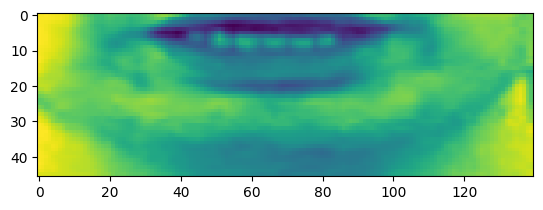

In [398]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [399]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white by o nine soon'>

# 3. Design the Deep Neural Network

In [400]:
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [401]:
test.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [402]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [403]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_12 (Activation)  (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 75, 23, 70, 128)  0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_13 (Activation)  (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 75, 11, 35, 256)  0         
 g3D)                                                 

In [404]:
5*17*75

6375

In [405]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [406]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'111111111111111111111111111111111111111111111111111111111111111111111111111'>

In [407]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'111111111111111111111111111111111111111111111111111111111111111111111111111'>

In [408]:
model.input_shape

(None, 75, 46, 140, 1)

In [409]:
model.output_shape

(None, 75, 41)

In [410]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [411]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [412]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [413]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [414]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [415]:
schedule_callback = LearningRateScheduler(scheduler)

In [416]:
example_callback = ProduceExample(test)

In [417]:
#model.fit(train, validation_data=test, epochs=0, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [418]:
#url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
#output = 'checkpoints.zip'
#gdown.download(url, output, quiet=False)
gdown.extractall('models - checkpoint 50.zip', 'models')

['models\\__MACOSX/models/._checkpoint.index',
 'models\\__MACOSX/models/._checkpoint',
 'models\\__MACOSX/models/._checkpoint.data-00000-of-00001',
 'models\\checkpoint.data-00000-of-00001',
 'models\\checkpoint.index',
 'models\\checkpoint']

In [419]:
model.load_weights('models/checkpoint')

In [420]:
test_data = test.as_numpy_iterator()

In [421]:
sample = test_data.next()

In [422]:
yhat = model.predict(sample[0])

1/1 [==============================] - 3s 3s/step


In [423]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue with j four please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set green with j seven again'>]

In [424]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [425]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]
#bin blue at f two now

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'se ben s seve slease'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'se lee in s six plaien'>]

# Test on a Video

In [426]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bbaf2n.mpg'))

In [427]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]

In [428]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 763ms/step


In [429]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [430]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'se blee bt s sisi please'>]